<img src="https://avatars.githubusercontent.com/u/61354833" align="left" width="70" height="70">

Code by [TomMakesThings](https://github.com/TomMakesThings/Genome-Sequence-Analysis-HMM)

# **About**
In this notebook, two variants of a perceptron are implemented from scratch to classify 10 binary inputs (xᵢ = +/-1) according to whether:
<ol type="I">
  <li>Their sum Σxᵢ is positive or negative</li>
  <li>The parity of the inputs ∏xᵢ, i.e. the sign of their product, is positive or negative</li>
</ol>

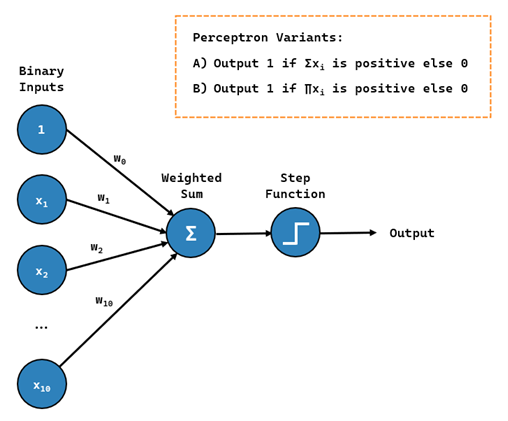

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

# Seed for reproducability
random.seed(5401767)

# Data Generation

Training, testing and validation data is generated as an array of n random sequences with 10 binary digits, either -1 or 1. For the sum sign problem, the matching label for each sequence is inferred as 1 if the sum is positive and 0 if it is negative. For the product parity problem, 1 denotes the product sign is positive, while 0 is negative.

In [2]:
# Function to create binary samples with labels
def generateSamples(options = [-1,1], n_values = 10, n_samples = 100, classifier_type = "sum"):
    # Randomly generate data
    data = np.array([[random.choice(options) for i in range(n_values)] for j in range(n_samples)])
    if (classifier_type == "sum"):
        # Assign binary labels, where 1 is positive sum and 0 is negative sum
        labels = np.array([int(sum(x) >= 0) for x in data])
    else:
        # Assign binary labels, where 1 is positive sign product and 0 is negative sign
        labels = np.array([math.prod(x) for x in data])
        labels = np.where(labels == -1, 0, labels)
    return(data, labels)

In [3]:
# Generate training, testing and validation data
x_train_sum, y_train_sum = generateSamples(n_samples = 1000)
x_val_sum, y_val_sum = generateSamples(n_samples = 100)
x_test_sum, y_test_sum = generateSamples(n_samples = 100)

x_train_product, y_train_product = generateSamples(n_samples = 1000, classifier_type = "product")
x_val_product, y_val_product = generateSamples(n_samples = 100, classifier_type = "product")
x_test_product, y_test_product = generateSamples(n_samples = 100, classifier_type = "product")

# Perceptron

In [4]:
class Perceptron():
    """
    n_neurons: the size of the input layer
    bias_weight: weight to initialise bias unit
    learning_rate: step size to change weights
    epochs: number of training iterations
    activation_function: use step or sigmoid activation function
    """
    def __init__(self, n_neurons, bias_weight = 0, learning_rate = 0.1, activation_function = "sigmoid"):
        # Set parameters
        self.n_neurons = n_neurons
        self.bias_weight = bias_weight
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        # Initialise network weights and bias
        self.weights = self.initialiseWeights()
        
    def initialiseWeights(self):
        # Randomly initialise weights from a normal distribution
        random_weights = np.random.randn(self.n_neurons)
        # Add the bias weight to index zero
        weights = np.append(self.bias_weight, random_weights)
        return(weights)
        
    def shuffleData(self, data, labels):
        # Add data into a dataframe
        df = pd.DataFrame(data = data)
        df["label"] = labels
        # Shuffle rows
        df = df.sample(frac = 1)
        # Extract data and labels
        shuffled_data = np.array(df.loc[:, df.columns != "label"])
        shuffled_labels = np.array(df["label"])
        return(shuffled_data, shuffled_labels)
    
    def predict(self, data, labels):
        # Record network predictions for each value
        predictions = np.array([])
        
        for value in data:
            # Dot product of the weights and input vector values plus bias
            output = sum(self.weights[1:] * value) + self.weights[0]
            
            # Apply activation function
            if (self.activation_function.lower() == "sigmoid"):
                # Sigmoid activation function
                prediction = 1/(1 + math.exp(-output))
            else:
                # Step activation function
                prediction = int(output > 0)
            predictions = np.append(predictions, prediction)
            
        return(predictions)
        
    def train(self, train_data, train_labels, val_data = None, val_labels = None,
              epochs = 100, shuffle = True):
        
        # Record error over epochs
        all_train_mse, all_val_mse = list(), list()
        
        # Run for a specified number of epochs
        for epoch in range(epochs):
            if (shuffle):
                # Shuffle the order of the training data
                train_data, train_labels = self.shuffleData(train_data, train_labels)
                
            # Record training and validation error for the epoch
            train_error = 0
            val_error = 0
            
            # Make predictions over all data
            predictions = self.predict(train_data, train_labels)
                
            # Iterate over predictions, samples and labels
            for pred, value, label in zip(predictions, train_data, train_labels):
                # For each sample, update the model weights
                weight_update = self.learning_rate * (label - pred)
                self.weights[0] += weight_update
                self.weights[1:] += weight_update * value
                
                # Add square of the differences between the predicted and expected output
                train_error += (pred - label)**2
                
            # Check if validation data given
            if (not isinstance(val_data, type(None))):
                # Make predictions on validation data
                val_predictions = self.predict(val_data, val_labels)
                # Record the validation loss
                for pred, label in zip(val_predictions, val_labels):
                    val_error += (pred - label)**2
                    
                # Calculate validation MSE
                all_val_mse.append(val_error/len(val_data))
            
            # Calculate mean squared error (MSE) for training data
            all_train_mse.append(train_error/len(train_data))
            
            # Stop training if train MSE is 0
            if all_train_mse[len(all_train_mse)-1] == 0:
                break
                
        return(all_train_mse, all_val_mse)
    
    def calculateAccuracy(self, truth, prediction):
        # Accuracy between expected and predicted outputs
        accuracy = np.sum(np.equal(truth, prediction)) / len(truth)
        return(accuracy)

# Training and Testing

To initialise the network, learning rate is specified, the maximum number of epochs set and the activation function set as the step function. The model's weights i = 1, ..., N are randomly initialised by sampling from a normal distribution with mean μ of 0 and variance σ of 1, while the bias unit's weight is set as zero. The perceptron is set to train until the max number of epochs is reached, or stops early if the training loss converges to 0. Within an epoch, data is randomly shuffled and the perceptron makes a prediction per sample. This prediction is derived from the raw output, i.e. the dot product of the weights and input vector values plus bias, passed through an activation function. Since the step activation function is set, predictions are 0 if the raw output is less than 0, and 1 otherwise. The difference between the predicted output and expected output is calculated and multiplied by the learning rate to determine the magnitude to update weights. For the bias unit, the weights are updated by directly adding this value, while for other nodes the weight update is multiplied by the sample's value. At the end of an epoch, training error is recorded via the mean squared error (MSE) loss function. The perceptron's performance is also evaluated on validation data and once training is complete, training and validation MSE are returned.

In [5]:
# Initialise the perceptrons
perceptron_sum = Perceptron(n_neurons = 10, learning_rate = 0.01, activation_function = "step")
perceptron_product = Perceptron(n_neurons = 10, learning_rate = 0.01, activation_function = "step")
# Train the perceptrons
train_error_sum, val_error_sum = perceptron_sum.train(x_train_sum, y_train_sum, x_val_sum, y_val_sum,
                                                      epochs = 50)
train_error_product, val_error_product = perceptron_product.train(x_train_product, y_train_product,
                                                                  x_val_product, y_val_product,
                                                                  epochs = 50)

To evaluate training, MSE is plotted over time. For the sum sign problem, both training and validation loss converge quickly to 0 allowing training to be stopped early. The network generalises well as is able to be trained to achieve 100% accuracy on unseen test data. By contrast, the product parity problem, loss does not converge and fluctuation can be observed due to the per sample, stochastic nature of weight updates. Attempting to train over a larger number of epochs and tune learning rate does not help model convergence. This is because the parity problem, which is a generalisation of the XOR problem, is not linearly separable. Therefore, unlike the sum problem, it is not solvable using a single-layer perceptron requires a multi-layer perceptron.

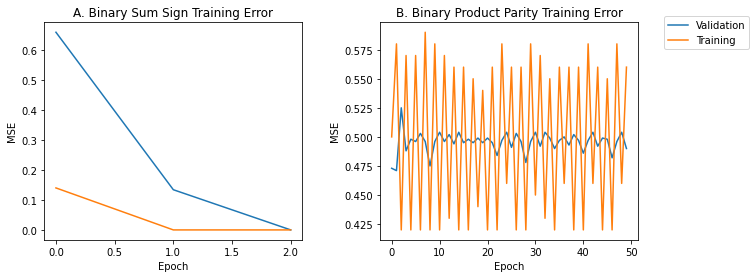

In [7]:
# Create plot of training error over epochs
fig, axes = plt.subplots(1, 2)
# Adjust space between subplots
plt.subplots_adjust(right = 1.5, wspace = 0.3)

# Add data
axes[0].plot(train_error_sum, label = 'Training')
axes[0].plot(val_error_sum, label = 'Validation')
axes[0].title.set_text('A. Binary Sum Sign Training Error')
axes[1].plot(train_error_product, label = 'Validation')
axes[1].plot(val_error_product, label = 'Training')
axes[1].title.set_text('B. Binary Product Parity Training Error')

# Set labels
for ax in axes.flat:
    ax.set(xlabel = 'Epoch', ylabel = 'MSE')
    
# Add legend, save and display plot
plt.legend(bbox_to_anchor = (1.45, 1.05))
plt.savefig("training_error.pdf", bbox_inches = 'tight')
plt.show()

In [8]:
# Calculate accuracy on test set
y_pred_sum = perceptron_sum.predict(x_test_sum, y_test_sum)
y_pred_product = perceptron_sum.predict(x_test_product, y_test_product)
print("Binary sum sign accuracy: " + str(perceptron_sum.calculateAccuracy(y_test_sum, y_pred_sum) * 100) + "%")
print("Binary product parity accuracy: " + str(perceptron_product.calculateAccuracy(y_test_product, y_pred_product) * 100) + "%")

Binary sum sign accuracy: 100.0%
Binary product parity accuracy: 36.0%
